## Library Setup

In [4]:
!pip install scikit-image
!pip install scikit-learn
!pip install opencv-python
!pip install opencv-contrib-python
!pip install numpy
!pip install matplotlib
!pip install scikit-optimize
!pip install tqdm
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 4.3 MB/s eta 0:00:24
   ---------------------------------------- 0.2/99.8 MB 2.8 MB/s eta 0:00:37
   ---------------------------------------- 0.4/99.8 MB 3.1 MB/s eta 0:00:33
   ---------------------------------------- 0.5/99.8 MB 2.8 MB/s eta 0:00:36
   ---------------------------------------- 0.8/99.8 MB 3.8 MB/s eta 0:00:26
   ---------------------------------------- 1.0/99.8 MB 3.5 MB/s eta 0:00:29
   ---------------------------------------- 1.2/99.8 MB 3.5 MB/s eta 0:00:29
    --------------------------------------- 1.3/99.8 MB 3.4 MB/s eta 0:00:30
    --------------------------------------- 1.5/99.8 MB 3.6 MB/s eta 0:00:28
    --------------------------------------- 1.8/99.8 MB 4.0 MB/s eta 0:00:25
    --------------------------------------- 2.2/99.8 MB 4.3 MB/s eta 0:00:23
    --------------------------------------- 2.4/99.8 MB 4.4 MB/s eta 0:00:22
   - -

## Dataset Download

In [101]:
!git clone https://github.com/folfcoder/recaptcha-dataset.git

Cloning into 'recaptcha-dataset'...
Updating files:   6% (719/11779)
Updating files:   7% (825/11779)
Updating files:   8% (943/11779)
Updating files:   9% (1061/11779)
Updating files:  10% (1178/11779)
Updating files:  11% (1296/11779)
Updating files:  11% (1330/11779)
Updating files:  12% (1414/11779)
Updating files:  13% (1532/11779)
Updating files:  14% (1650/11779)
Updating files:  15% (1767/11779)
Updating files:  16% (1885/11779)
Updating files:  16% (1943/11779)
Updating files:  17% (2003/11779)
Updating files:  18% (2121/11779)
Updating files:  19% (2239/11779)
Updating files:  20% (2356/11779)
Updating files:  21% (2474/11779)
Updating files:  21% (2539/11779)
Updating files:  22% (2592/11779)
Updating files:  23% (2710/11779)
Updating files:  24% (2827/11779)
Updating files:  25% (2945/11779)
Updating files:  26% (3063/11779)
Updating files:  27% (3181/11779)
Updating files:  27% (3194/11779)
Updating files:  28% (3299/11779)
Updating files:  29% (3416/11779)
Updating files:

In [48]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt    

## Preprocessing

In [13]:
#### Point processing

# contrast_stretching
def contrast_stretching(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

def log_trans(image):
    # scale the pixel values to avoid log(0)
    c = 255 / np.log(1 + np.max(image))  # scale factor
    log_transformed_image = c * np.log(1 + image)  # apply log transformation formula
    
    # convert back to uint8
    log_transformed_image = np.array(log_transformed_image, dtype=np.uint8)

    return log_transformed_image

def power_law(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def high_boost_filtering(image, highpass, A=1.5):
    high_boosted = (A-1)*image+highpass
    high_boosted = np.clip(high_boosted, 0, 255)
    high_boosted = np.uint8(high_boosted)

    return high_boosted

def sharpening(image):
    blur_gauss = cv2.GaussianBlur(image, (3,3), sigmaX=10,sigmaY= 10)
    image32 = np.float32(image)
    blur_gauss32 = np.float32(blur_gauss)

    # Subtract the Gaussian blurred image from the original/processed image to get the high frequency components
    mask = cv2.subtract(image32, blur_gauss32)

    alpha = 1.5
    sharpened_image = cv2.addWeighted(image32, 3+alpha, mask, -3-alpha, 0)
    sharpened_image = cv2.convertScaleAbs(sharpened_image)

    return sharpened_image

def opening(image):
    kernel = np.ones((2,2), np.uint8)
    opening_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    return opening_image

def closing(image):
    kernel = np.ones((2,2), np.uint8)
    opening_image = cv2.morphologyEx(image, cv2.MORPH_CROSS, kernel)

    return opening_image

In [55]:
# Load the image in grayscale # 3, 9, 10, 11
image_path = 'C:/Users/gdeok/Computer-Vision/early-vision/recaptcha-dataset/Large/Bicycle/Bicycle (3).png'
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found")
original_image=image

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# contrast stretching
#image= contrast_stretching(image)

# log transform
#image = log_trans(image)

# law-power stretching
#iamge = power_law(image, gamma=0.5)

#strech_image = image

image = cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0, sigmaY=0)

# Equalized Histogram
equalized_image=cv2.equalizeHist(image)

# sharpening Image
igb=cv2.GaussianBlur(original_image, ksize=(3,3), sigmaX=0, sigmaY=0)
sharp = cv2.addWeighted(original_image, 2, igb, -1, 0)

#### Area processing

In [16]:
# blur filtering
blur_gauss = cv2.GaussianBlur(equalized_image, (3,3), sigmaX=2,sigmaY=2, )

In [17]:
# edge
## Canny operator
ret, otsu_thresh_image = cv2.threshold(blur_gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lower = int(max(0, 0.5 * ret))
upper = int(min(255, 1.5 * ret))
edge_canny=cv2.Canny(blur_gauss, lower, upper)

## Sobel Operator
sobelx = cv2.Sobel(blur_gauss, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3, delta=128)
sobely = cv2.Sobel(blur_gauss, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3, delta=128)
gradient_magnitude = cv2.magnitude(sobelx, sobely)

## LoG
log = cv2.Laplacian(equalized_image, -1, ksize=3, scale=1.5)

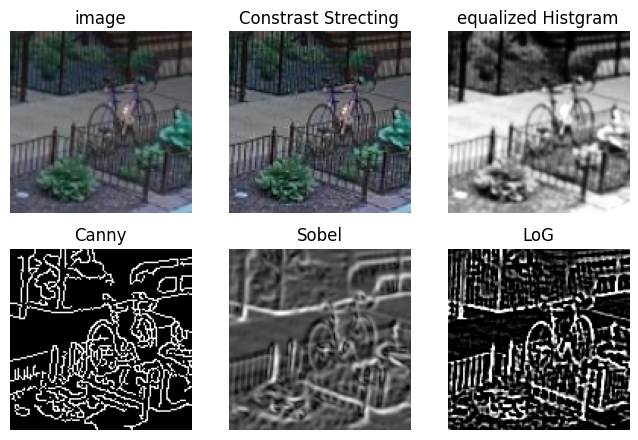

In [52]:
# visualization
plt.figure(figsize=(8, 8))

plt.subplot(3, 3, 1)
plt.title('image')
plt.axis('off')
plt.imshow(original_image)

plt.subplot(3, 3, 2)
plt.title('Constrast Strecting')
plt.axis('off')
plt.imshow(sharp)

plt.subplot(3, 3, 3)
plt.title('equalized Histgram')
plt.axis('off')
plt.imshow(equalized_image, cmap='gray')

plt.subplot(3, 3, 4)
plt.title('Canny')
plt.axis('off')
plt.imshow(edge_canny, cmap='gray')

plt.subplot(3, 3, 5)
plt.title('Sobel')
plt.axis('off')
plt.imshow(gradient_magnitude, cmap='gray')

plt.subplot(3, 3, 6)
plt.title('LoG')
plt.axis('off')
plt.imshow(log, cmap='gray')

## Mid Level Features

### Color

히스토그램 크기: (512,)
히스토그램 값: [0.05964825 0.5871784  0.698063   0.39574322 0.08781549 0.00688249
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        

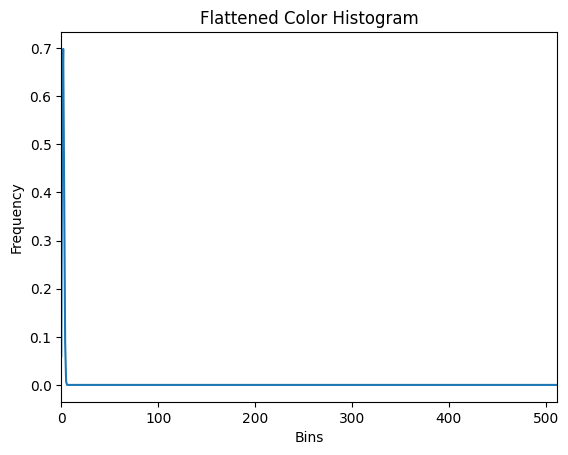

In [60]:
def hsv_histogram(image, bins=(8, 8, 8)):
    # 이미지가 grayscale인지 확인하고 컬러 이미지로 변환
    if len(image.shape) == 2:
       image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    gb=cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0, sigmaY=0)
    
    # HSV 색공간으로 변환
    hsv_image = cv2.cvtColor(gb, cv2.COLOR_BGR2HSV)
    
    # 히스토그램 계산 및 정규화
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    
    return hist.flatten()

hist = hsv_histogram(image, bins=(8,8,8))

# 히스토그램 출력
print("히스토그램 크기:", hist.shape)
print("히스토그램 값:", hist.flatten())

# 히스토그램 시각화 
plt.figure()
plt.title("Flattened Color Histogram")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.plot(hist.flatten())
plt.xlim([0, 512])
plt.show()

### Texture

#### $ LBP_{P,R}^{riu2} $

In [9]:
class LBP_riu2:
    def __init__(self, P=8, R=1):
        self.P = P  # Number of points
        self.R = R  # Radius
        self.angles = np.arange(P) * (2 * np.pi / P)
        self.cos_angles = R * np.cos(self.angles)
        self.sin_angles = R * np.sin(self.angles)

    def _thresholded(self, center, pixels):
        return (pixels >= center).astype(int)

    def s(self, x):
        return 1 if x >= 0 else 0

    def _uniformity(self, pattern):
        transitions = np.sum(pattern[:-1] != pattern[1:]) + (pattern[-1] != pattern[0])
        return transitions

    def _get_pixel_neighbors(self, image, center_x, center_y):
        x = self.cos_angles + center_x
        y = self.sin_angles + center_y
        x = np.clip(x, 0, image.shape[1] - 1).astype(int)
        y = np.clip(y, 0, image.shape[0] - 1).astype(int)
        return image[y, x]

    def _rotate_to_min(self, binary_pattern):
        # Rotate the binary pattern to its minimum value (circularly)
        min_pattern = binary_pattern
        min_value = np.sum(binary_pattern * (1 << np.arange(len(binary_pattern))))
        for i in range(1, len(binary_pattern)):
            rotated_pattern = np.roll(binary_pattern, i)
            rotated_value = np.sum(rotated_pattern * (1 << np.arange(len(rotated_pattern))))
            if rotated_value < min_value:
                min_value = rotated_value
                min_pattern = rotated_pattern
        return min_pattern
    
    def compute_lbp(self, image):
        rows, cols = image.shape
        lbp_image = np.zeros((rows - 2 * self.R, cols - 2 * self.R), dtype=np.uint8)

        for i in range(self.R, rows - self.R):
            for j in range(self.R, cols - self.R):
                center = image[i, j]
                pixels = self._get_pixel_neighbors(image, j, i)
                binary_pattern = self._thresholded(center, pixels)
                uniformity = self._uniformity(binary_pattern)
                if uniformity <= 2:
                    rotated_pattern = self._rotate_to_min(binary_pattern)
                    lbp_value = np.sum(rotated_pattern * (1 << np.arange(self.P)))
                else:
                    lbp_value = self.P + 1
                lbp_image[i - self.R, j - self.R] = lbp_value
        return lbp_image

    def compute_histogram(self, lbp_image):
        n_bins = self.P + 2  # Number of bins to account for all patterns
        hist, _ = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, n_bins))
        hist = hist.astype("float")
        hist /= hist.sum()  # Normalize the histogram
        return hist


#### $ Var_{P, R} $

In [10]:
class Var:
    def __init__(self, P=8):
        self.P = P
        self.angles = np.arange(P) * (2 * np.pi / P)
        self.cos_angles = np.cos(self.angles)
        self.sin_angles = np.sin(self.angles)

    def _get_pixel_neighbors(self, image, center_x, center_y, R):
        x = R * self.cos_angles + center_x
        y = R * self.sin_angles + center_y
        x = np.clip(x, 0, image.shape[1] - 1).astype(int)
        y = np.clip(y, 0, image.shape[0] - 1).astype(int)
        return image[y, x]

    def compute_var(self, image, R):
        rows, cols = image.shape
        var_image = np.zeros((rows - 2 * R, cols - 2 * R), dtype=np.float32)
        
        for i in range(R, rows - R):
            for j in range(R, cols - R):
                neighbors = self._get_pixel_neighbors(image, j, i, R)
                mu = np.mean(neighbors)
                var_image[i - R, j - R] = np.sum((neighbors - mu) ** 2) / self.P
        
        return var_image

#### $LBP_{P,R}^{riu2} / VAR_{P,R} $  $ MultiResolution $

In [11]:
def compute_lbp_var_multiresolution(image, params):
    combined_histogram = np.zeros(26)
    #lbp_histograms = []
    #var_histograms = []
    lbp_var_features = []

    for P, R in params:
        # Compute LBP features
        lbp_extractor = LBP_riu2(P=P, R=R)
        lbp_image = lbp_extractor.compute_lbp(image)
        lbp_histogram = lbp_extractor.compute_histogram(lbp_image)
        #lbp_histograms.append(lbp_histogram)
        
        # Compute VAR features
        var_extractor = Var(P=P)
        var_image = var_extractor.compute_var(image, R)
        n_bins = P + 2
        var_histogram, _ = np.histogram(var_image.ravel(), bins=n_bins, range=(0, var_image.max() + 1e-7))
        var_histogram = var_histogram.astype("float")
        var_histogram /= var_histogram.sum()
        #var_histograms.append(var_histogram)

        # Compute LBP+VAR features
        lbp_var = lbp_histogram + var_histogram
        lbp_var_features.append(lbp_var)

        # Combine histograms
        if P == 8 and R == 1:
            combined_histogram[:len(lbp_var)] += lbp_var
        elif P == 24 and R == 3:
            combined_histogram[-len(lbp_var):] += lbp_var
    
    return combined_histogram 
#, lbp_histograms, var_histograms, lbp_var_features

"""
# Example usage
params = [(8, 1), (24, 3)]
combined_histogram = compute_lbp_var_multiresolution(equalized_image, params)
#, lbp_histograms, var_histograms, lbp_var_features

#lbp_var_hist = pd.DataFrame(lbp_var_features)
#lbp_var_hist.to_csv('lpb_var_hist.csv', index=False)

combined_hist = pd.DataFrame(combined_histogram.reshape(1, -1))
combined_hist.to_csv('combined_hist.csv', index=False)

num_params = len(params)
fig, axes = plt.subplots(num_params + 1, 3, figsize=(8, 5 * (num_params + 1)))

for idx, (lbp_hist, var_hist, lbp_var_hist, (P, R)) in enumerate(zip(lbp_histograms, var_histograms, lbp_var_features, params)):
    axes[idx, 0].bar(range(len(lbp_hist)), lbp_hist, color='blue', alpha=0.7)
    axes[idx, 0].set_title(f'LBP Histogram (P={P}, R={R})')
    
    axes[idx, 1].bar(range(len(var_hist)), var_hist, color='green', alpha=0.7)
    axes[idx, 1].set_title(f'VAR Histogram (P={P}, R={R})')
    
    axes[idx, 2].bar(range(len(lbp_var_hist)), lbp_var_hist, color='red', alpha=0.7)
    axes[idx, 2].set_title(f'LBP+VAR Histogram (P={P}, R={R})')

# Plot combined histogram
axes[-1, 0].bar(range(len(combined_histogram)), combined_histogram, color='purple', alpha=0.7)
axes[-1, 0].set_title('Combined Histogram')

# Hide unused subplots in the last row
for ax in axes[-1, 1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
"""

"\n# Example usage\nparams = [(8, 1), (24, 3)]\ncombined_histogram = compute_lbp_var_multiresolution(equalized_image, params)\n#, lbp_histograms, var_histograms, lbp_var_features\n\n#lbp_var_hist = pd.DataFrame(lbp_var_features)\n#lbp_var_hist.to_csv('lpb_var_hist.csv', index=False)\n\ncombined_hist = pd.DataFrame(combined_histogram.reshape(1, -1))\ncombined_hist.to_csv('combined_hist.csv', index=False)\n\nnum_params = len(params)\nfig, axes = plt.subplots(num_params + 1, 3, figsize=(8, 5 * (num_params + 1)))\n\nfor idx, (lbp_hist, var_hist, lbp_var_hist, (P, R)) in enumerate(zip(lbp_histograms, var_histograms, lbp_var_features, params)):\n    axes[idx, 0].bar(range(len(lbp_hist)), lbp_hist, color='blue', alpha=0.7)\n    axes[idx, 0].set_title(f'LBP Histogram (P={P}, R={R})')\n    \n    axes[idx, 1].bar(range(len(var_hist)), var_hist, color='green', alpha=0.7)\n    axes[idx, 1].set_title(f'VAR Histogram (P={P}, R={R})')\n    \n    axes[idx, 2].bar(range(len(lbp_var_hist)), lbp_var_hist

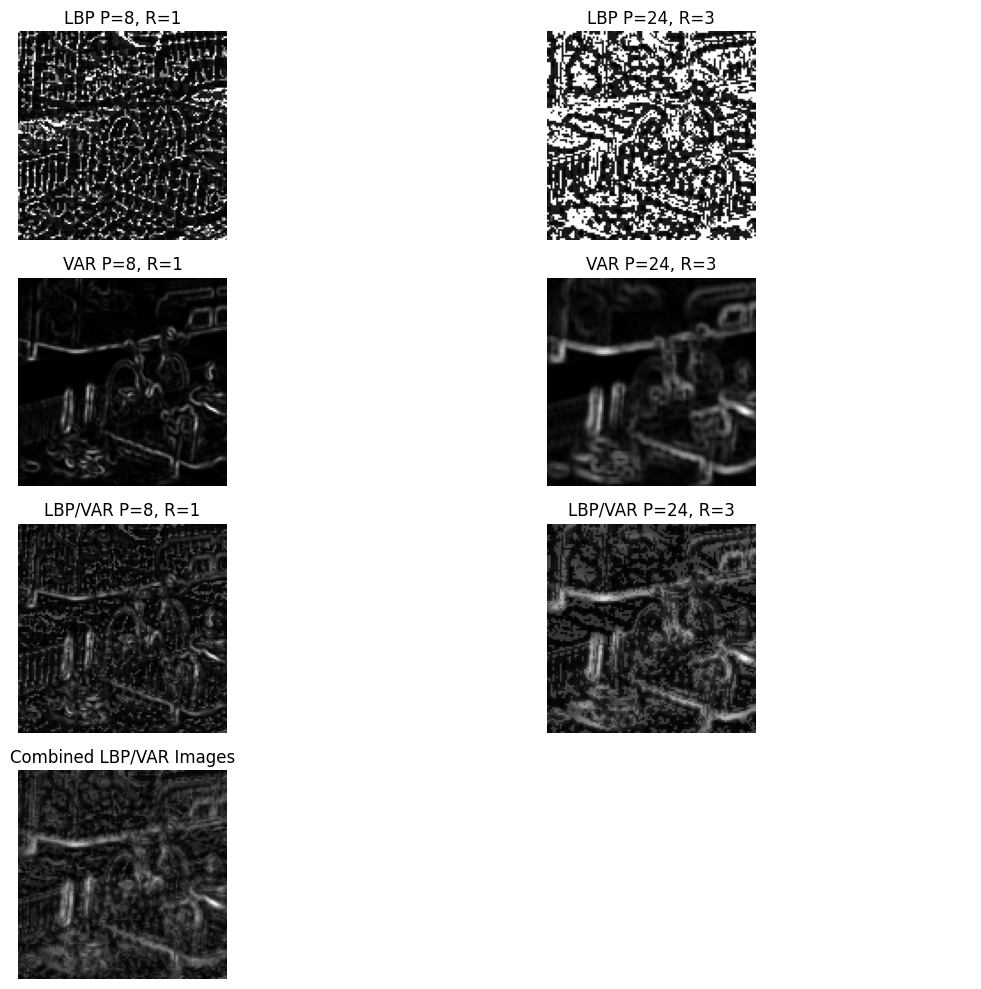

In [36]:
def resize_image(image, target_shape):
    return cv2.resize(image, target_shape, interpolation=cv2.INTER_AREA)

def compute_lbp_var_images(image, params):
    lbp_images = []
    var_images = []
    lbp_var_images = []
    combined_images = None

    for P, R in params:
        # Compute LBP features
        lbp_extractor = LBP_riu2(P=P, R=R)
        lbp_image = lbp_extractor.compute_lbp(image)
        lbp_images.append(lbp_image)
        
        # Compute VAR features
        var_extractor = Var(P=P)
        var_image = var_extractor.compute_var(image, R)
        var_images.append(var_image)
        
        # Resize images to the same shape
        target_shape = min(lbp_image.shape, var_image.shape)
        lbp_image_resized = resize_image(lbp_image, target_shape)
        var_image_resized = resize_image(var_image, target_shape)
        
        # Normalize LBP and VAR images
        lbp_image_normalized = lbp_image_resized / lbp_image_resized.sum()
        var_image_normalized = var_image_resized / var_image_resized.sum()

        # Compute LBP+VAR image
        lbp_var_image = lbp_image_normalized + var_image_normalized
        lbp_var_images.append(lbp_var_image)

        # Combine LBP+VAR images
        if combined_images is None:
            combined_images = lbp_var_image
        else:
            combined_images = resize_image(combined_images, lbp_var_image.shape)
            combined_images += lbp_var_image

    return lbp_images, var_images, lbp_var_images, combined_images

# Example usage
params = [(8, 1), (24, 3)]
lbp_images, var_images, lbp_var_images, combined_images = compute_lbp_var_images(equalized_image, params)

fig, axes = plt.subplots(4, len(params), figsize=(12, 10))
for idx, (lbp_img, var_img, lbp_var_img, (P, R)) in enumerate(zip(lbp_images, var_images, lbp_var_images, params)):
    axes[0, idx].imshow(lbp_img, cmap='gray')
    axes[0, idx].set_title(f'LBP P={P}, R={R}')
    axes[0, idx].axis('off')

    axes[1, idx].imshow(var_img, cmap='gray')
    axes[1, idx].set_title(f'VAR P={P}, R={R}')
    axes[1, idx].axis('off')

    axes[2, idx].imshow(lbp_var_img, cmap='gray')
    axes[2, idx].set_title(f'LBP/VAR P={P}, R={R}')
    axes[2, idx].axis('off')

axes[3, 0].imshow(combined_images, cmap='gray')
axes[3, 0].set_title('Combined LBP/VAR Images')
axes[3, 0].axis('off')

# Remove axes for the combined image to the right
for idx in range(1, len(params)):
    axes[3, idx].axis('off')

plt.tight_layout()
plt.show()

#### GLCM

In [19]:
from skimage.feature import graycomatrix, graycoprops

class GaborGLCM:
    def __init__(self, ksize=11, sigma=4.0, lambd=10.0, gamma=0.5, psi=0, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
        self.ksize = ksize
        self.sigma = sigma
        self.lambd = lambd
        self.gamma = gamma
        self.psi = psi
        self.distances = distances
        self.angles = angles
        self.kernels = self.build_gabor_kernels()
    
    def build_gabor_kernels(self):
        theta_values = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        kernels = []
        for theta in theta_values:
            kernel = cv2.getGaborKernel((self.ksize, self.ksize), self.sigma, theta, self.lambd, self.gamma, self.psi, ktype=cv2.CV_64F)
            kernels.append(kernel)
        return kernels

    def apply_gabor_filters(self, image):
        filtered_images = []
        for kernel in self.kernels:
            filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            filtered_images.append(filtered_image)
        return filtered_images
    
    def compute_glcm_features(self, image):
        glcm = graycomatrix(image, distances=self.distances, angles=self.angles, levels=256, symmetric=True, normed=True)
        features = {
            'contrast': graycoprops(glcm, 'contrast').mean(),
            'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
            'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
            'energy': graycoprops(glcm, 'energy').mean(),
            'correlation': graycoprops(glcm, 'correlation').mean(),
            'ASM': graycoprops(glcm, 'ASM').mean(),
        }
        return features

    def compute_combined_features(self, image):
        gabor_filtered_images = self.apply_gabor_filters(image)
        
        combined_features = {
            'contrast': 0,
            'dissimilarity': 0,
            'homogeneity': 0,
            'energy': 0,
            'correlation': 0,
            'ASM': 0
        }
        
        # Compute the number of combinations
        num_combinations = len(gabor_filtered_images) * len(self.distances) * len(self.angles)
        
        for filtered_image in gabor_filtered_images:
            for d in self.distances:
                for a in self.angles:
                    glcm = graycomatrix(filtered_image, distances=[d], angles=[a], levels=256, symmetric=True, normed=True)
                    combined_features['contrast'] += graycoprops(glcm, 'contrast').mean()
                    combined_features['dissimilarity'] += graycoprops(glcm, 'dissimilarity').mean()
                    combined_features['homogeneity'] += graycoprops(glcm, 'homogeneity').mean()
                    combined_features['energy'] += graycoprops(glcm, 'energy').mean()
                    combined_features['correlation'] += graycoprops(glcm, 'correlation').mean()
                    combined_features['ASM'] += graycoprops(glcm, 'ASM').mean()
        
        # Average the features by the number of combinations
        for key in combined_features:
            combined_features[key] /= num_combinations
        
        return combined_features

### Shape

#### SIFT

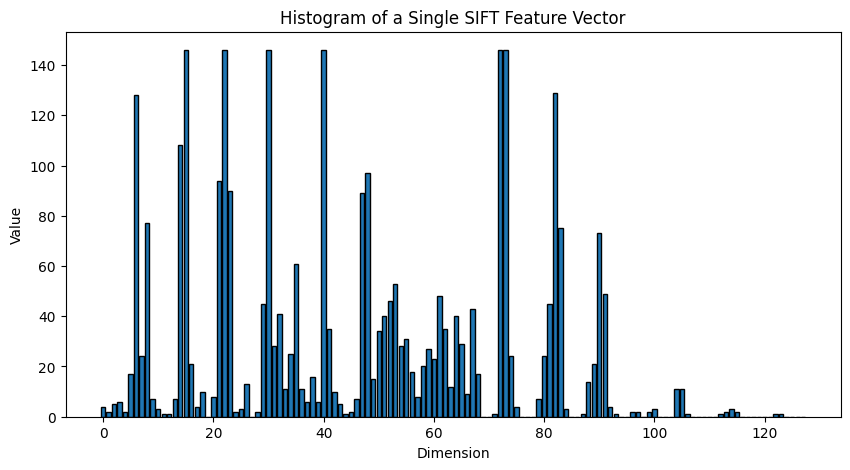

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(equalized_image, None)

# Check if keypoints and descriptors are found
if descriptors is not None and len(descriptors) > 0:
    # Select the first descriptor for visualization
    sift_feature_vector = descriptors[0]

    # Create a histogram for the first SIFT feature vector
    plt.figure(figsize=(10, 5))
    plt.bar(range(128), sift_feature_vector, width=0.8, edgecolor='black')
    plt.title('Histogram of a Single SIFT Feature Vector')
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.show()
else:
    print("No SIFT features detected in the image.")


## Feature Extraction

In [58]:
# Dataset path and labels
dataset_path = 'C:/Users/gdeok/Computer-Vision/early-vision/recaptcha-dataset/Large'
labels = ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Palm', 'Traffic Light']
#labels=['Bicycle']

### Color

In [61]:
def extract_hsv_features(dataset_path, labels, bins=(8, 8, 8)):
    all_histograms = []
    filenames = []
    image_labels = []
    i = 0
    
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.png'):
                image_path = os.path.join(label_path, filename)
                image = cv2.imread(image_path)
                gb = cv2.GaussianBlur(image, ksize=(3,3), sigmaX=0, sigmaY=0)
                
                if gb is not None:
                    # 컬러 히스토그램 추출
                    hist = hsv_histogram(gb, bins)
                    
                    all_histograms.append(hist)
                    filenames.append(os.path.splitext(filename)[0])  # 파일 확장자 제거
                    image_labels.append(label)
                else:
                    print(f"Image not found: {image_path}")
                
        print(f"Feature extraction completed for label: {label}\n")
    # Stack all histograms vertically in a numpy array
    if all_histograms:
        all_histograms = np.array(all_histograms)
    else:
        print("No histograms found. Exiting.")
        return None, None, None
    
    return all_histograms, filenames, image_labels

bins = (8, 8, 8)

all_histograms, filenames, image_labels = extract_hsv_features(dataset_path, labels, bins)

# DataFrame으로 변환
df_features = pd.DataFrame(all_histograms, index=filenames)
df_features['label'] = image_labels

# CSV 파일로 저장
df_features.to_csv('./feature/hsv_color_histograms.csv', index_label='filename')

Feature extraction completed for label: Bicycle

1000
Feature extraction completed for label: Bridge

2000
Feature extraction completed for label: Bus

3000
4000
5000
6000
Feature extraction completed for label: Car

Feature extraction completed for label: Chimney

7000
Feature extraction completed for label: Crosswalk

8000
Feature extraction completed for label: Hydrant

Feature extraction completed for label: Motorcycle

9000
Feature extraction completed for label: Palm

10000
Feature extraction completed for label: Traffic Light



### LBP

In [ ]:
def LBP_feature_extraction(dataset_path, labels, params):
    lbp_features = []
    all_labels = []
    file_names = []
    
    i=0
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.png'):
                file_path = os.path.join(label_path, filename)
                
                image = cv2.imread(file_path)
                if image is None:
                    raise ValueError("Image not found")
                
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                blur_image=cv2.GaussianBlur(gray_image, (3,3), sigmaX=0,sigmaY=0,)
                equalized_image=cv2.equalizeHist(blur_image)
                
                # Compute multi-resolution LBP features
                combined_histogram = compute_lbp_var_multiresolution(equalized_image, params)
                
                # Append to the list
                lbp_features.append(combined_histogram)
                all_labels.append(label)
                file_names.append(os.path.splitext(filename)[0])  # 파일 이름 저장
            
            i += 1
            print(i)

        print(f"Feature extraction completed for label: {label}\n")

    return np.array(lbp_features), np.array(all_labels), file_names

params = [(8, 1), (24, 3)]
lbp_features, labels, file_names = LBP_feature_extraction(dataset_path=dataset_path, labels=labels, params=params)

# Convert to DataFrame for further processing or saving
df_features = pd.DataFrame(lbp_features, index=file_names)
df_labels = pd.Series(labels, index=file_names)
df_combined_lbp = pd.concat([df_features, df_labels], axis=1)

# Save to CSV (optional)
df_combined_lbp.to_csv('./feature/df_combine_lbp_blureq.csv', index=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### GLCM

In [11]:
def GLCM_feature_extraction(dataset_path, labels, gabor_glcm):
    all_features = []
    all_labels = []
    file_names = []
    
    i = 0
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.png'):
                file_path = os.path.join(label_path, filename)
                
                image = cv2.imread(file_path)
                if image is None:
                    raise ValueError(f"Image not found: {file_path}")
                
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                blur_image = cv2.GaussianBlur(gray_image, (3, 3), sigmaX=0, sigmaY=0)
                equalized_image = cv2.equalizeHist(blur_image)
                
                features = gabor_glcm.compute_combined_features(equalized_image)
                all_features.append(features)
                all_labels.append(label)
                file_names.append(os.path.splitext(filename)[0])  # Strip file extension

                i += 1
                print(i)
                
        print(f"Feature extraction completed for label: {label}")
    
    return pd.DataFrame(all_features, index=file_names), np.array(all_labels), file_names

distances = [1, 2, 3]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

gabor_glcm = GaborGLCM(ksize=11, distances=distances, angles=angles)

# Compute combined features for the dataset
features_df, labels, file_names = GLCM_feature_extraction(dataset_path, labels, gabor_glcm)

# Add labels to the DataFrame
features_df['label'] = labels

# Save to CSV (optional)
features_df.to_csv('./feature/combined_GLCM.csv', index_label='file_name')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### SIFT

In [7]:
from sklearn.cluster import KMeans

def extract_sift_descriptors(dataset_path, labels):
    # Initialize SIFT
    sift = cv2.SIFT_create()

    all_descriptors = []
    filenames = []
    image_labels = []
    i = 0
    
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.png'):
                image_path = os.path.join(label_path, filename)
                gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                blur_image=cv2.GaussianBlur(gray_image, (3,3), sigmaX=0,sigmaY=0,)
                equalized_image=cv2.equalizeHist(blur_image)
                sharp = cv2.addWeighted(gray_image, 2, equalized_image, -1, 0)
                if sharp is not None:
                    keypoints, descriptors = sift.detectAndCompute(sharp, None)
                    if descriptors is not None:
                        all_descriptors.append(descriptors)
                        filenames.append(os.path.splitext(filename)[0])  # Strip file extension
                        image_labels.append(label)
                else:
                    print(f"Image not found: {image_path}")
                i += 1
                if i % 1000 == 0:
                    print(i)
    
    # Stack all descriptors vertically in a numpy array
    if all_descriptors:
        all_descriptors = np.vstack(all_descriptors)
    else:
        print("No descriptors found. Exiting.")
        return None, None, None
    
    return all_descriptors, filenames, image_labels

all_descriptors, filenames, image_labels = extract_sift_descriptors(dataset_path, labels)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

def find_optimal_k_Elbow(descriptors, max_k=70):
    inertia = []
    K = range(30, max_k + 1)
    
    print("Computing inertia for different values of k...")
    for k in tqdm(K, desc="Elbow Method Progress"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(descriptors)
        inertia.append(kmeans.inertia_)
        print(f'k={k}, inertia={kmeans.inertia_}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

    return K, inertia

def find_optimal_k_silhouette(descriptors, max_k=60):
    silhouette_scores = []
    K = range(55, max_k + 1)  # Silhouette score is undefined for k=1
    
    print("Computing silhouette scores for different values of k...")
    for k in tqdm(K, desc="Silhouette Method Progress"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(descriptors)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(descriptors, labels)
        silhouette_scores.append(silhouette_avg)
        print(f'k={k}, silhouette score={silhouette_avg:.5f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Method for Optimal k')
    plt.grid(True)
    plt.show()

    # Find the optimal k with the highest silhouette score
    optimal_k = K[np.argmax(silhouette_scores)]
    highest_silhouette_score = max(silhouette_scores)
    print(f'Optimal k based on silhouette score: {optimal_k} with a silhouette score of {highest_silhouette_score:.4f}')
    
    return K, silhouette_scores, optimal_k 


# Find the optimal number of clusters
#K, inertia = find_optimal_k_Elbow(all_descriptors)
#K, silhouette_scores, optimal_k = find_optimal_k_silhouette(all_descriptors)
#print(optimal_k)

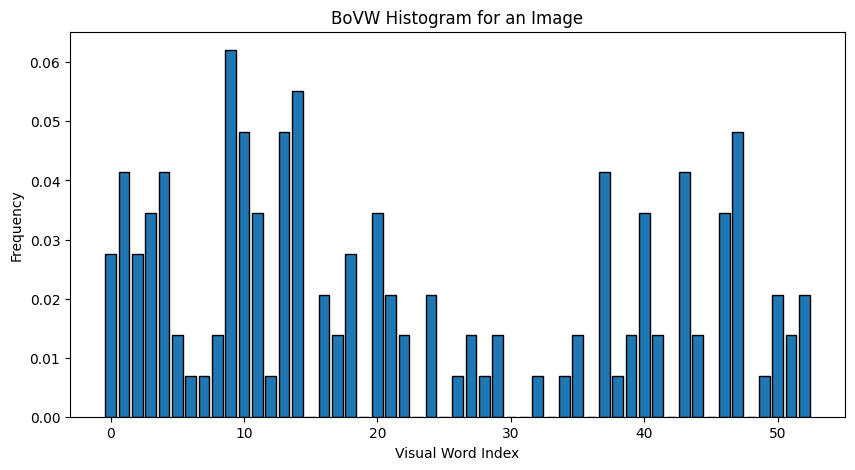

In [11]:
# Set k to 10 based on the Elbow Method and labels
# silhouette -> 53~55  전체 데이터셋은 53 에서 엘보 발생
k = 53
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(all_descriptors)

# Function to compute BoVW histograms
def compute_bovw_histogram(descriptors, kmeans):
    visual_words = kmeans.predict(descriptors)
    hist, _ = np.histogram(visual_words, bins=np.arange(kmeans.n_clusters + 1))
    hist = hist / hist.sum() # Normalization
    return hist

# Extract individual descriptors again for computing histograms
sift = cv2.SIFT_create()
histograms = []

for label in labels:
    label_path = os.path.join(dataset_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.png'):
            image_path = os.path.join(label_path, filename)
            gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            blur_image = cv2.GaussianBlur(gray_image, (3, 3), sigmaX=0, sigmaY=0)
            equalized_image = cv2.equalizeHist(blur_image)
            sharp = cv2.addWeighted(gray_image, 2, equalized_image, -1, 0)
            
            if sharp is not None:
                keypoints, descriptors = sift.detectAndCompute(sharp, None)
                if descriptors is not None:
                    hist = compute_bovw_histogram(descriptors, kmeans)
                    histograms.append(hist)


# Convert histograms and labels to DataFrame
df_histograms = pd.DataFrame(histograms, index=filenames)
df_histograms['label'] = image_labels

# Save the DataFrame to a CSV file
df_histograms.to_csv("./feature/bovw_histograms.csv")

# Optional: Plotting one of the histograms for visualization
plt.figure(figsize=(10, 5))
plt.bar(range(len(histograms[0])), histograms[0], width=0.8, edgecolor='black')
plt.title('BoVW Histogram for an Image')
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.show()

## Feature Transform

### PCA

In [66]:
from sklearn.decomposition import PCA

def apply_pca(data, explained_variance_threshold=0.99):
    """
    Apply PCA to the data and reduce its dimensionality.

    Parameters:
    data (numpy.ndarray): The input data to reduce.
    explained_variance_threshold (float): The threshold of cumulative explained variance for selecting the number of components.

    Returns:
    numpy.ndarray: The reduced data.
    PCA: The fitted PCA model.
    """
    pca = PCA()
    pca.fit(data)
    
    # Calculate cumulative explained variance
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find the number of components that explain the desired variance
    num_components = np.argmax(cumulative_explained_variance >= explained_variance_threshold) + 1
    
    # Apply PCA with the optimal number of components
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(data)
    
    print(f"Number of components selected: {num_components}")
    
    # Plot cumulative explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_explained_variance, marker='o')
    plt.axhline(y=explained_variance_threshold, color='r', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()
    
    return reduced_data, pca

Number of components selected: 135


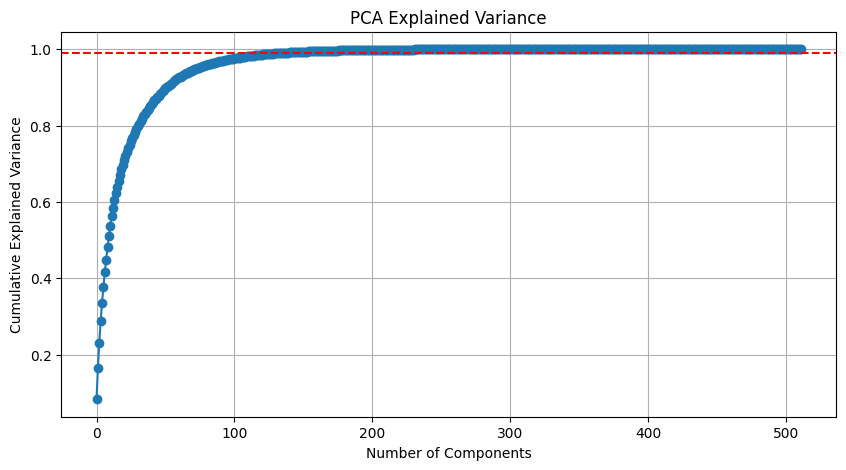

In [67]:
df_histograms = pd.read_csv("./feature/hsv_color_histograms.csv", index_col=0)

# Extract features and labels
X = df_histograms.drop('label', axis=1).values
labels = df_histograms['label'].values
indices = df_histograms.index

# Apply PCA for dimension reduction
reduced_data, pca_model = apply_pca(X)

# Create a DataFrame from the reduced data
df_reduced = pd.DataFrame(reduced_data, index=indices)

# Add the labels back to the DataFrame
df_reduced['label'] = labels

# Save the DataFrame to a CSV file
df_reduced.to_csv("./feature/reduced_hsv_color_histograms.csv")

## Classification

### KNN

In [24]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# 데이터셋 로드
data_path = './feature/merged_features_lbp_bovw_glcm.csv'
df = pd.read_csv(data_path, index_col=0)

# 특징과 레이블 분리
X = df.drop('label', axis=1).values
y = df['label'].values

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# KNN 모델 생성
knn = KNeighborsClassifier(n_neighbors=2)

# 5-폴드 교차 검증을 위한 StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5)

accuracies = []
precisions = []
recalls = []
fold = 0

print("교차 검증 시작...")

for train_index, test_index in tqdm(skf.split(X, y_encoded), total=5, desc='Cross-validation'):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print(f'\n{fold}번째 폴드 학습 중...')
    
    # 학습 데이터셋으로 KNN 모델 학습
    knn.fit(X_train, y_train)
    
    # 테스트 데이터셋으로 KNN 모델 평가
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f'{fold}번째 폴드 정확도: {accuracy:.2f}')
    print(f'{fold}번째 폴드 정밀도: {precision:.2f}')
    print(f'{fold}번째 폴드 재현율: {recall:.2f}')

# 평균 성능 지표 계산
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f'\n평균 정확도: {average_accuracy:.2f}')
print(f'평균 정밀도: {average_precision:.2f}')
print(f'평균 재현율: {average_recall:.2f}')


교차 검증 시작...


Cross-validation:  40%|████      | 2/5 [00:00<00:00, 14.34it/s]


1번째 폴드 학습 중...
1번째 폴드 정확도: 0.23
1번째 폴드 정밀도: 0.21
1번째 폴드 재현율: 0.23

2번째 폴드 학습 중...
2번째 폴드 정확도: 0.22
2번째 폴드 정밀도: 0.20
2번째 폴드 재현율: 0.22

3번째 폴드 학습 중...
3번째 폴드 정확도: 0.23
3번째 폴드 정밀도: 0.21
3번째 폴드 재현율: 0.23

4번째 폴드 학습 중...


Cross-validation: 100%|██████████| 5/5 [00:00<00:00, 13.45it/s]

4번째 폴드 정확도: 0.21
4번째 폴드 정밀도: 0.20
4번째 폴드 재현율: 0.21

5번째 폴드 학습 중...
5번째 폴드 정확도: 0.22
5번째 폴드 정밀도: 0.20
5번째 폴드 재현율: 0.22

평균 정확도: 0.22
평균 정밀도: 0.20
평균 재현율: 0.22


### SVM

In [70]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# 데이터셋 로드
data_path = './feature/hsv_color_histograms_888.csv'
df = pd.read_csv(data_path, index_col=0)

# 특징과 레이블 분리
X = df.drop('label', axis=1).values
y = df['label'].values

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 단일 SVM 모델 생성
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

# 5-폴드 교차 검증을 위한 StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5)

accuracies = []
precisions = []
recalls = []
fold = 0

print("교차 검증 시작...")

for train_index, test_index in tqdm(skf.split(X, y_encoded), total=5, desc='Cross-validation'):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print(f'\n{fold}번째 폴드 학습 중...')
    
    # 학습 데이터셋으로 SVM 모델 학습
    svm.fit(X_train, y_train)
    
    # 테스트 데이터셋으로 SVM 모델 평가
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f'{fold}번째 폴드 정확도: {accuracy:.2f}')
    print(f'{fold}번째 폴드 정밀도: {precision:.2f}')
    print(f'{fold}번째 폴드 재현율: {recall:.2f}')

# 평균 성능 지표 계산
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f'\n평균 정확도: {average_accuracy:.2f}')
print(f'평균 정밀도: {average_precision:.2f}')
print(f'평균 재현율: {average_recall:.2f}')


교차 검증 시작...


Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]


1번째 폴드 학습 중...


Cross-validation:  20%|██        | 1/5 [00:06<00:25,  6.48s/it]

1번째 폴드 정확도: 0.48
1번째 폴드 정밀도: 0.49
1번째 폴드 재현율: 0.48

2번째 폴드 학습 중...


Cross-validation:  40%|████      | 2/5 [00:12<00:19,  6.47s/it]

2번째 폴드 정확도: 0.49
2번째 폴드 정밀도: 0.51
2번째 폴드 재현율: 0.49

3번째 폴드 학습 중...


Cross-validation:  60%|██████    | 3/5 [00:19<00:12,  6.47s/it]

3번째 폴드 정확도: 0.47
3번째 폴드 정밀도: 0.47
3번째 폴드 재현율: 0.47

4번째 폴드 학습 중...


Cross-validation:  80%|████████  | 4/5 [00:26<00:06,  6.59s/it]

4번째 폴드 정확도: 0.47
4번째 폴드 정밀도: 0.48
4번째 폴드 재현율: 0.47

5번째 폴드 학습 중...


Cross-validation: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]

5번째 폴드 정확도: 0.47
5번째 폴드 정밀도: 0.47
5번째 폴드 재현율: 0.47

평균 정확도: 0.47
평균 정밀도: 0.48
평균 재현율: 0.47


### XGBoosting

In [68]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# 데이터셋 로드
data_path = './feature/reduced_hsv_color_histograms.csv'
df = pd.read_csv(data_path, index_col=0)

# 특징과 레이블 분리
X = df.drop('label', axis=1).values
y = df['label'].values

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Best parameters: OrderedDict([('colsample_bytree', 0.8773989904628025), ('gamma', 0.5), ('learning_rate', 0.1552133806741601), 
# ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 50), ('subsample', 0.6)])

# Best parameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.01), ('max_depth', 5), 
# ('min_child_weight', 10), ('n_estimators', 10), ('subsample', 0.6559828406940449)])

# Best parameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.5), ('learning_rate', 0.02138269878764605), ('max_depth', 3), 
# ('min_child_weight', 1), ('n_estimators', 312), ('subsample', 0.6)])

# XGBoost 모델 생성
xgb = make_pipeline(StandardScaler(), XGBClassifier())

# 5-폴드 교차 검증을 위한 StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5)

accuracies = []
precisions = []
recalls = []
fold = 0

print("교차 검증 시작...")

for train_index, test_index in tqdm(skf.split(X, y_encoded), total=5, desc='Cross-validation'):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print(f'\n{fold}번째 폴드 학습 중...')
    
    # 학습 데이터셋으로 XGBoost 모델 학습
    xgb.fit(X_train, y_train)
    
    # 테스트 데이터셋으로 XGBoost 모델 평가
    y_pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f'{fold}번째 폴드 정확도: {accuracy:.2f}')
    print(f'{fold}번째 폴드 정밀도: {precision:.2f}')
    print(f'{fold}번째 폴드 재현율: {recall:.2f}')

# 평균 성능 지표 계산
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f'\n평균 정확도: {average_accuracy:.2f}')
print(f'평균 정밀도: {average_precision:.2f}')
print(f'평균 재현율: {average_recall:.2f}')

교차 검증 시작...


Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]


1번째 폴드 학습 중...


Cross-validation:  20%|██        | 1/5 [00:13<00:54, 13.72s/it]

1번째 폴드 정확도: 0.49
1번째 폴드 정밀도: 0.48
1번째 폴드 재현율: 0.49

2번째 폴드 학습 중...


Cross-validation:  40%|████      | 2/5 [00:26<00:39, 13.25s/it]

2번째 폴드 정확도: 0.49
2번째 폴드 정밀도: 0.49
2번째 폴드 재현율: 0.49

3번째 폴드 학습 중...


Cross-validation:  60%|██████    | 3/5 [00:41<00:28, 14.06s/it]

3번째 폴드 정확도: 0.47
3번째 폴드 정밀도: 0.47
3번째 폴드 재현율: 0.47

4번째 폴드 학습 중...


Cross-validation:  80%|████████  | 4/5 [00:54<00:13, 13.55s/it]

4번째 폴드 정확도: 0.48
4번째 폴드 정밀도: 0.48
4번째 폴드 재현율: 0.48

5번째 폴드 학습 중...


Cross-validation: 100%|██████████| 5/5 [01:06<00:00, 13.31s/it]

5번째 폴드 정확도: 0.48
5번째 폴드 정밀도: 0.48
5번째 폴드 재현율: 0.48

평균 정확도: 0.48
평균 정밀도: 0.48
평균 재현율: 0.48


### Logistic Regression

In [71]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# 데이터셋 로드
data_path = './feature/hsv_color_histograms_888.csv'
df = pd.read_csv(data_path, index_col=0)

# 특징과 레이블 분리
X = df.drop('label', axis=1).values
y = df['label'].values

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 로지스틱 회귀 모델 생성
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, multi_class='multinomial', solver='lbfgs'))

# 5-폴드 교차 검증을 위한 StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5)

accuracies = []
precisions = []
recalls = []
fold = 0

print("교차 검증 시작...")

for train_index, test_index in tqdm(skf.split(X, y_encoded), total=5, desc='Cross-validation'):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print(f'\n{fold}번째 폴드 학습 중...')
    
    # 학습 데이터셋으로 로지스틱 회귀 모델 학습
    log_reg.fit(X_train, y_train)
    
    # 테스트 데이터셋으로 로지스틱 회귀 모델 평가
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f'{fold}번째 폴드 정확도: {accuracy:.2f}')
    print(f'{fold}번째 폴드 정밀도: {precision:.2f}')
    print(f'{fold}번째 폴드 재현율: {recall:.2f}')

# 평균 성능 지표 계산
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f'\n평균 정확도: {average_accuracy:.2f}')
print(f'평균 정밀도: {average_precision:.2f}')
print(f'평균 재현율: {average_recall:.2f}')


교차 검증 시작...


Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]


1번째 폴드 학습 중...


Cross-validation:  20%|██        | 1/5 [00:03<00:13,  3.47s/it]

1번째 폴드 정확도: 0.49
1번째 폴드 정밀도: 0.48
1번째 폴드 재현율: 0.49

2번째 폴드 학습 중...


Cross-validation:  40%|████      | 2/5 [00:06<00:09,  3.25s/it]

2번째 폴드 정확도: 0.49
2번째 폴드 정밀도: 0.48
2번째 폴드 재현율: 0.49

3번째 폴드 학습 중...


Cross-validation:  60%|██████    | 3/5 [00:10<00:06,  3.43s/it]

3번째 폴드 정확도: 0.47
3번째 폴드 정밀도: 0.46
3번째 폴드 재현율: 0.47

4번째 폴드 학습 중...


Cross-validation:  80%|████████  | 4/5 [00:13<00:03,  3.46s/it]

4번째 폴드 정확도: 0.48
4번째 폴드 정밀도: 0.46
4번째 폴드 재현율: 0.48

5번째 폴드 학습 중...


Cross-validation: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

5번째 폴드 정확도: 0.47
5번째 폴드 정밀도: 0.46
5번째 폴드 재현율: 0.47

평균 정확도: 0.48
평균 정밀도: 0.47
평균 재현율: 0.48


### Random Forest

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

# 데이터셋 로드
data_path = './feature/merged_features_lbp_bovw_glcm.csv'
df = pd.read_csv(data_path, index_col=0)

# 특징과 레이블 분리
X = df.drop('label', axis=1).values
y = df['label'].values

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 랜덤 포레스트 모델 생성
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))

# 5-폴드 교차 검증을 위한 StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5)

accuracies = []
precisions = []
recalls = []
fold = 0

print("교차 검증 시작...")

for train_index, test_index in tqdm(skf.split(X, y_encoded), total=5, desc='Cross-validation'):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print(f'\n{fold}번째 폴드 학습 중...')
    
    # 학습 데이터셋으로 랜덤 포레스트 모델 학습
    rf.fit(X_train, y_train)
    
    # 테스트 데이터셋으로 랜덤 포레스트 모델 평가
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f'{fold}번째 폴드 정확도: {accuracy:.2f}')
    print(f'{fold}번째 폴드 정밀도: {precision:.2f}')
    print(f'{fold}번째 폴드 재현율: {recall:.2f}')

# 평균 성능 지표 계산
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f'\n평균 정확도: {average_accuracy:.2f}')
print(f'평균 정밀도: {average_precision:.2f}')
print(f'평균 재현율: {average_recall:.2f}')


교차 검증 시작...


Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]


1번째 폴드 학습 중...


Cross-validation:  20%|██        | 1/5 [00:05<00:20,  5.07s/it]

1번째 폴드 정확도: 0.44
1번째 폴드 정밀도: 0.42
1번째 폴드 재현율: 0.44

2번째 폴드 학습 중...


Cross-validation:  40%|████      | 2/5 [00:10<00:15,  5.05s/it]

2번째 폴드 정확도: 0.44
2번째 폴드 정밀도: 0.41
2번째 폴드 재현율: 0.44

3번째 폴드 학습 중...


Cross-validation:  60%|██████    | 3/5 [00:15<00:10,  5.05s/it]

3번째 폴드 정확도: 0.46
3번째 폴드 정밀도: 0.46
3번째 폴드 재현율: 0.46

4번째 폴드 학습 중...


Cross-validation:  80%|████████  | 4/5 [00:20<00:05,  5.05s/it]

4번째 폴드 정확도: 0.43
4번째 폴드 정밀도: 0.42
4번째 폴드 재현율: 0.43

5번째 폴드 학습 중...


Cross-validation: 100%|██████████| 5/5 [00:25<00:00,  5.06s/it]

5번째 폴드 정확도: 0.42
5번째 폴드 정밀도: 0.45
5번째 폴드 재현율: 0.42

평균 정확도: 0.44
평균 정밀도: 0.43
평균 재현율: 0.44


### Hyper parameter Search

In [23]:
import logging
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# 데이터셋 로드
data_path = './feature/reduced_df_combined_lbp_blureq.csv'
df = pd.read_csv(data_path, index_col=0)

# 특징과 레이블 분리
X = df.drop('label', axis=1).values
y = df['label'].values

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 로깅 설정
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('skopt')
logger.setLevel(logging.DEBUG)

# XGBoost 모델 설정
xgb =  XGBClassifier()


# 베이지안 최적화 설정
opt = BayesSearchCV(
    xgb,
    {
        'n_estimators': (5, 500),
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'max_depth': (3, 10),
        'min_child_weight': (1, 10),
        'gamma': (0.0, 0.5),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    scoring='accuracy',
    n_iter=50,
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=1
)

# 최적화 실행
opt.fit(X, y_encoded)

# 결과 출력
print("Best parameters:", opt.best_params_)
print("Best score:", opt.best_score_)

# 테스트 세트에 대해 최적의 모델 평가
best_model = opt.best_estimator_

# StratifiedKFold를 사용한 교차 검증
skf = StratifiedKFold(n_splits=5)

accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_index, test_index in skf.split(X, y_encoded):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

print(f'\n평균 정확도: {np.mean(accuracies):.4f}')
print(f'평균 정밀도: {np.mean(precisions):.4f}')
print(f'평균 재현율: {np.mean(recalls):.4f}')
print(f'평균 F1 점수: {np.mean(f1_scores):.4f}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\gdeok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gdeok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gdeok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:


평균 정확도: 0.3740
평균 정밀도: 0.3079
평균 재현율: 0.3740
평균 F1 점수: 0.2780


C:\Users\gdeok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Ensemble

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 데이터셋 로드
data_path = './feature/merged_features_lbp_sift_glcm_hsv.csv'
df = pd.read_csv(data_path, index_col=0)

# 특징과 레이블 분리
X = df.drop('label', axis=1).values
y = df['label'].values

# 문자열 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 개별 모델 생성
svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True))
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
log_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
#knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))

# 앙상블 모델 생성 (VotingClassifier)
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm),
    ('xgb', xgb),
    ('log_reg', log_reg),
    ('rf', rf),
    #('knn', knn)
], voting='soft')

# 5-폴드 교차 검증을 위한 StratifiedKFold 설정
skf = StratifiedKFold(n_splits=5)

accuracies = []
precisions = []
recalls = []
fold = 0

print("교차 검증 시작...")

for train_index, test_index in tqdm(skf.split(X, y_encoded), total=5, desc='Cross-validation'):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print(f'\n{fold}번째 폴드 학습 중...')
    
    # 학습 데이터셋으로 앙상블 모델 학습
    ensemble_model.fit(X_train, y_train)
    
    # 테스트 데이터셋으로 앙상블 모델 평가
    y_pred = ensemble_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f'{fold}번째 폴드 정확도: {accuracy:.2f}')
    print(f'{fold}번째 폴드 정밀도: {precision:.2f}')
    print(f'{fold}번째 폴드 재현율: {recall:.2f}')

# 평균 성능 지표 계산
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

print(f'\n평균 정확도: {average_accuracy:.2f}')
print(f'평균 정밀도: {average_precision:.2f}')
print(f'평균 재현율: {average_recall:.2f}')


교차 검증 시작...


Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]


1번째 폴드 학습 중...


Cross-validation:  20%|██        | 1/5 [02:46<11:06, 166.71s/it]

1번째 폴드 정확도: 0.60
1번째 폴드 정밀도: 0.60
1번째 폴드 재현율: 0.60

2번째 폴드 학습 중...


Cross-validation:  40%|████      | 2/5 [05:19<07:54, 158.29s/it]

2번째 폴드 정확도: 0.61
2번째 폴드 정밀도: 0.62
2번째 폴드 재현율: 0.61

3번째 폴드 학습 중...


Cross-validation:  60%|██████    | 3/5 [07:50<05:10, 155.18s/it]

3번째 폴드 정확도: 0.60
3번째 폴드 정밀도: 0.60
3번째 폴드 재현율: 0.60

4번째 폴드 학습 중...


Cross-validation:  80%|████████  | 4/5 [10:17<02:32, 152.07s/it]

4번째 폴드 정확도: 0.60
4번째 폴드 정밀도: 0.61
4번째 폴드 재현율: 0.60

5번째 폴드 학습 중...


Cross-validation: 100%|██████████| 5/5 [12:43<00:00, 152.61s/it]

5번째 폴드 정확도: 0.60
5번째 폴드 정밀도: 0.61
5번째 폴드 재현율: 0.60

평균 정확도: 0.60
평균 정밀도: 0.61
평균 재현율: 0.60
